In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [7]:
# Load dataset
df = pd.read_csv(r'C:/Users/HP/Desktop/Mahesh/dr_final/train.csv')

# Dictionaries for mapping
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# Add columns for binary and detailed diagnosis
df['binary_type'] = df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()


,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


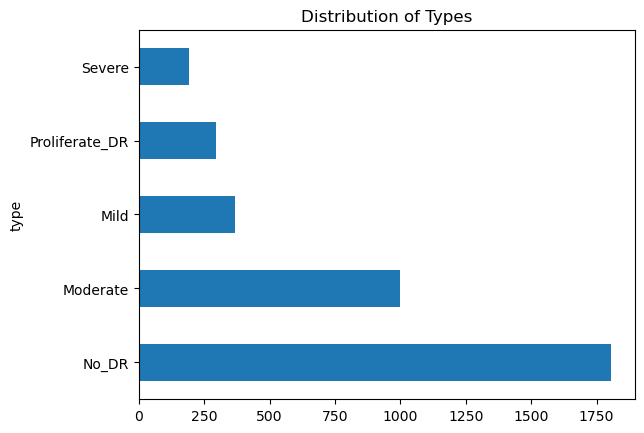

In [8]:
# Plot class distribution
df['type'].value_counts().plot(kind='barh')
plt.title('Distribution of Types')
plt.show()

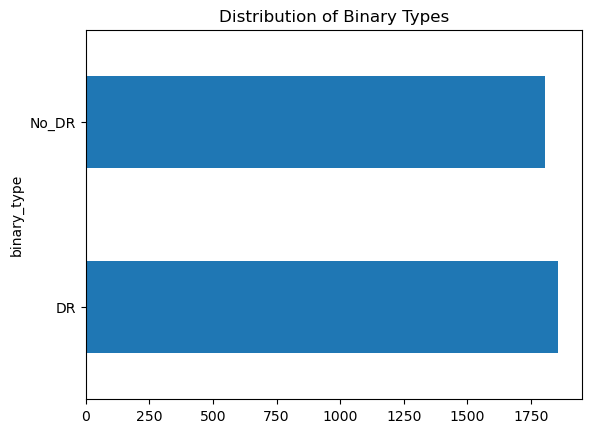

In [9]:
df['binary_type'].value_counts().plot(kind='barh')
plt.title('Distribution of Binary Types')
plt.show()

In [10]:
# Split data into train, val, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [11]:
# Create working directories for train/val/test
base_dir = 'working_directory'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [12]:
# Copy images to respective working directory
src_dir = r'C:/Users/HP/Desktop/Mahesh/dr_final/gaussian_filtered_images/gaussian_filtered_images'

def copy_images(dataframe, destination_dir):
    for index, row in dataframe.iterrows():
        diagnosis = row['type']
        binary_diagnosis = row['binary_type']
        id_code = row['id_code'] + ".png"
        srcfile = os.path.join(src_dir, diagnosis, id_code)
        dstfile = os.path.join(destination_dir, binary_diagnosis)
        os.makedirs(dstfile, exist_ok=True)
        shutil.copy(srcfile, dstfile)

copy_images(train, train_dir)
copy_images(val, val_dir)
copy_images(test, test_dir)


In [13]:
# Setting up ImageDataGenerator
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, target_size=(224, 224), shuffle=True)
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(224, 224), shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(224, 224), shuffle=False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [14]:
# Build and compile the model
model = Sequential([
    layers.Conv2D(8, (3, 3), padding="valid", input_shape=(224, 224, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3, 3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4, 4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [15]:
# Train the model
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

model.save('64x33-CNN.model')

Epoch 1/30
81/81 [==============================] - 76s 904ms/step - loss: 0.4239 - accuracy: 0.8318 - val_loss: 0.6741 - val_accuracy: 0.5073
Epoch 2/30
81/81 [==============================] - 53s 654ms/step - loss: 0.2729 - accuracy: 0.8872 - val_loss: 0.6768 - val_accuracy: 0.5073
Epoch 3/30
81/81 [==============================] - 53s 651ms/step - loss: 0.2424 - accuracy: 0.9048 - val_loss: 0.6353 - val_accuracy: 0.5818
Epoch 4/30
81/81 [==============================] - 53s 650ms/step - loss: 0.2218 - accuracy: 0.9137 - val_loss: 0.5571 - val_accuracy: 0.6455
Epoch 5/30
81/81 [==============================] - 53s 650ms/step - loss: 0.2137 - accuracy: 0.9180 - val_loss: 0.3780 - val_accuracy: 0.8291
Epoch 6/30
81/81 [==============================] - 53s 651ms/step - loss: 0.2030 - accuracy: 0.9282 - val_loss: 0.2690 - val_accuracy: 0.8982
Epoch 7/30
81/81 [==============================] - 53s 649ms/step - loss: 0.1937 - accuracy: 0.9309 - val_loss: 0.2189 - val_accuracy: 0.9218

INFO:tensorflow:Assets written to: 64x33-CNN.model\assets


In [16]:
# Evaluate the model
loss, acc = model.evaluate(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 6s 354ms/step - loss: 0.2073 - accuracy: 0.9382
Loss:  0.20728334784507751
Accuracy:  0.9381818175315857


In [17]:
# Prediction function
def predict_class(path):
    img = cv2.imread(path)
    if img is not None:
        RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        RGBImg = cv2.resize(RGBImg, (224, 224))
        plt.imshow(RGBImg)
        plt.axis('off')
        plt.show()

        image = np.array(RGBImg) / 255.0
        new_model = tf.keras.models.load_model("64x33-CNN.model")
        predict = new_model.predict(np.array([image]))
        per = np.argmax(predict, axis=1)
        if per == 0:
            print('No DR')
        else:
            print('DR')
    else:
        print("Failed to load the image.")

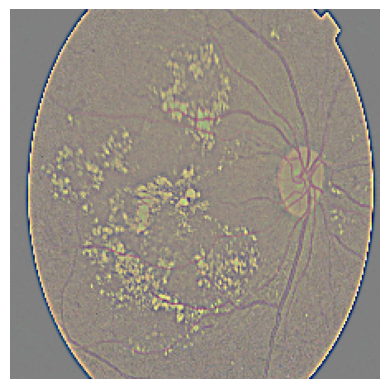

1/1 [==============================] - 0s 213ms/step
No DR


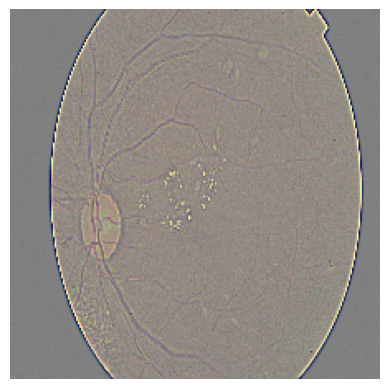

1/1 [==============================] - 0s 108ms/step
No DR


In [18]:
# Test prediction function
predict_class('C:/Users/HP/Desktop/Mahesh/dr_final/gaussian_filtered_images/gaussian_filtered_images/Severe/0f96c358a250.png')
predict_class('C:/Users/HP/Desktop/Mahesh/dr_final/gaussian_filtered_images/gaussian_filtered_images/Moderate/0c76fd494af6.png')
# predict_class('C:/Users/HP/Desktop/Mahesh/dr_final/gaussian_filtered_images/gaussian_filtered_images/No_DR/0b8bdec9d869.png')

In [19]:
import os

model_path = '64x33-CNN.h5'
# Change this to your actual file name if needed

if os.path.isfile(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")


Model file exists.


In [20]:
import os

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\HP


In [21]:
import os

# Check if file exists after saving
model_path = '64x33-CNN.h5'  # Update this to your file name if needed
if os.path.isfile(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")


Model file exists.


In [13]:
from tensorflow.keras.models import save_model

# Define the absolute path where you want to save the model
model_path = 'C:/Users/HP/Desktop/flask_app/models/64x33-CNN.h5'

try:
    model.save(model_path)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [29]:
import os

# Check if file exists after saving
model_path = '64x33-CNN.h5'  # Update this to your file name if needed
if os.path.isfile(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")


Model file exists.


In [30]:
from tensorflow.keras.models import save_model

# Train the model
history = model.fit(
    train_batches,
    epochs=30,
    validation_data=val_batches
)

# Save the model in HDF5 format
model.save('64x33-CNN.h5')

print("Model saved successfully as '64x33-CNN.h5'.")


Epoch 1/30
81/81 [==============================] - 46s 563ms/step - loss: 0.0734 - accuracy: 0.9797 - val_loss: 0.1714 - val_accuracy: 0.9382
Epoch 2/30
81/81 [==============================] - 46s 567ms/step - loss: 0.0708 - accuracy: 0.9781 - val_loss: 0.1716 - val_accuracy: 0.9382
Epoch 3/30
81/81 [==============================] - 49s 608ms/step - loss: 0.0670 - accuracy: 0.9824 - val_loss: 0.1750 - val_accuracy: 0.9309
Epoch 4/30
81/81 [==============================] - 47s 585ms/step - loss: 0.0676 - accuracy: 0.9828 - val_loss: 0.1711 - val_accuracy: 0.9364
Epoch 5/30
81/81 [==============================] - 48s 593ms/step - loss: 0.0636 - accuracy: 0.9848 - val_loss: 0.1725 - val_accuracy: 0.9364
Epoch 6/30
81/81 [==============================] - 47s 579ms/step - loss: 0.0604 - accuracy: 0.9809 - val_loss: 0.1720 - val_accuracy: 0.9382
Epoch 7/30
81/81 [==============================] - 47s 576ms/step - loss: 0.0575 - accuracy: 0.9883 - val_loss: 0.1726 - val_accuracy: 0.9364

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully as '64x33-CNN.h5'.


In [25]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
    print("pickle saved successfully")

pickle saved successfully
